In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import random
import time
import datetime
import math
from tqdm import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageOps, ImageEnhance
import cv2 
import numba.cuda as cuda
from sklearn.model_selection import StratifiedKFold

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import albumentations as A
import albumentations.pytorch

import timm

from optimizers import SAM, Lookahead, Ralamb, AdamP
from losses import (bi_tempered_logistic_loss, SmoothCrossEntropyLoss, FocalCosineLoss,
                    SymmetricCrossEntropy, TaylorCrossEntropyLoss)
from augmentations import snapmix, SnapMixLoss, RandomAugMix, GridMask

pd.set_option('display.max_rows', 5)

In [3]:
class CFG :
    time = datetime.datetime.now().strftime(format='%Y%m%d_%H%M%S')
    debug = False
    
    epochs = 40
    batch_size = 16
    device = 'cuda:0'
    verbose = 2
    seed = 666
    n_fold = 5
    
    img_size = 586
    crop_ratio = 0.875
    crop_size = int(img_size*crop_ratio)
    classes = [0,1,2,3,4]
    train_cache = True
    valid_cache = True
    num_workers = 6
    
    snapmix_pct = 0.5
    snapmix_alpha = 5
    gridmask_pct = 0.25
    gridmask_num = 3
    gridmask_mode = 3
    augmix_pct = 0.5
    augmix_severity = 2
    augmix_width = 3
    augmix_alpha = 0.1
    
    model = 'tf_efficientnet_b7_ns'
    
    optimizer = 'ralamb'
    lr = 1e-04
    momentum = 0.9
    eps = 1e-08
    betas = (0.9, 0.99)
    weight_decay = 1e-6
    amsgrad = True
    lookahead = False
    swa = False
    
    # LOSS
    # cross_entropy, bi_tempered_logistic, smooth_cross_entropy
    # focal_cosine, symmetric_cross_entropy, taylor_cross_entropy
    loss = 'bi_tempered_logistic'
    t0 = 0.8
    t1 = 1.2
    label_smoothing=0.2
    
    scheduler = 'cosine'
    cos_t0 = 10
    min_lr = 1e-6
    
    early_stop_epochs = epochs
    save_best = True
    
CFG.crop_size

512

In [4]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

seed_everything(CFG.seed)

In [5]:
# TRAIN_IMG_PATH = '../input/cassava-leaf-disease-classification/train_images'
# TRAIN_DF = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
TRAIN_IMG_PATH = '../input/cassava-leaf-disease-merged/train_images'
TRAIN_DF = pd.read_csv('../input/cassava-leaf-disease-merged/train.csv')
TRAIN_DF['path'] = [os.path.join(TRAIN_IMG_PATH, fn) for fn in TRAIN_DF.image_id]

In [6]:
if CFG.debug :
    CFG.epochs = 2
    CFG.n_fold = 3
    CFG.save_best = False
    TRAIN_DF = TRAIN_DF.iloc[:int(0.05*len(TRAIN_DF))]
    print('Debug Mode Activated')

# DataSet

In [7]:
class CassavaDataset(Dataset):
    def __init__(self, file_paths, labels,
                 transform=None, cache_ds=False, use_cache=False):
        self.file_paths = list(file_paths)
        self.labels = list(labels)
        self.transform = transform
        self.cached_images = []
        self.cached_labels = []
        self.cache_ds = cache_ds
        self.use_cache = use_cache
        
    def __len__(self):
        return len(self.file_paths)
    
    def set_use_cache(self, use_cache):
        self.use_cache = use_cache

    def __getitem__(self, idx):
        if not self.use_cache or self.cache_ds :
            label = self.labels[idx]
            file_path = self.file_paths[idx]

            # Read an image with OpenCV
            image = cv2.imread(file_path)

            # By default OpenCV uses BGR color space for color images,
            # so we need to convert the image to RGB color space.
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             image = cv2.resize(image, dsize=(CFG.img_size, CFG.img_size), 
#                                interpolation=cv2.INTER_CUBIC)

            if not self.cache_ds :
                self.cached_images.append(image)
                self.cached_labels.append(label)
        
        else :
            image = self.cached_images[idx]
            label = self.cached_labels[idx]

        if self.transform:
            augmented = self.transform(image=image) 
            image = augmented['image']
                
        return image, label

## Data Augmentations

### Set Transformations

In [8]:
train_transform = A.Compose([
    A.RandomResizedCrop(CFG.crop_size, CFG.crop_size),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=1),
    A.ShiftScaleRotate(p=0.5),
    
    RandomAugMix(
        severity=CFG.augmix_severity,
        width=CFG.augmix_width,
        alpha=CFG.augmix_alpha,
        p=CFG.augmix_pct),
    
    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
#     A.Cutout(p=0.5),
    A.OneOf([
        GridMask(num_grid=CFG.gridmask_num,
                 mode=CFG.gridmask_mode, 
                 rotate=15),
        GridMask(num_grid=CFG.gridmask_num,
                 mode=CFG.gridmask_mode,
                 rotate=15),
    ], p=CFG.gridmask_pct),
    A.pytorch.ToTensor(),
])

valid_transform = A.Compose([
#     A.CenterCrop(CFG.crop_size, CFG.crop_size, p=1.),
    A.RandomResizedCrop(CFG.crop_size, CFG.crop_size),
    A.Resize(CFG.crop_size, CFG.crop_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
    A.pytorch.ToTensor(),
])

inference_transform = A.Compose([
    A.RandomResizedCrop(CFG.crop_size, CFG.crop_size),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=1),
    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
    A.pytorch.ToTensor(),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


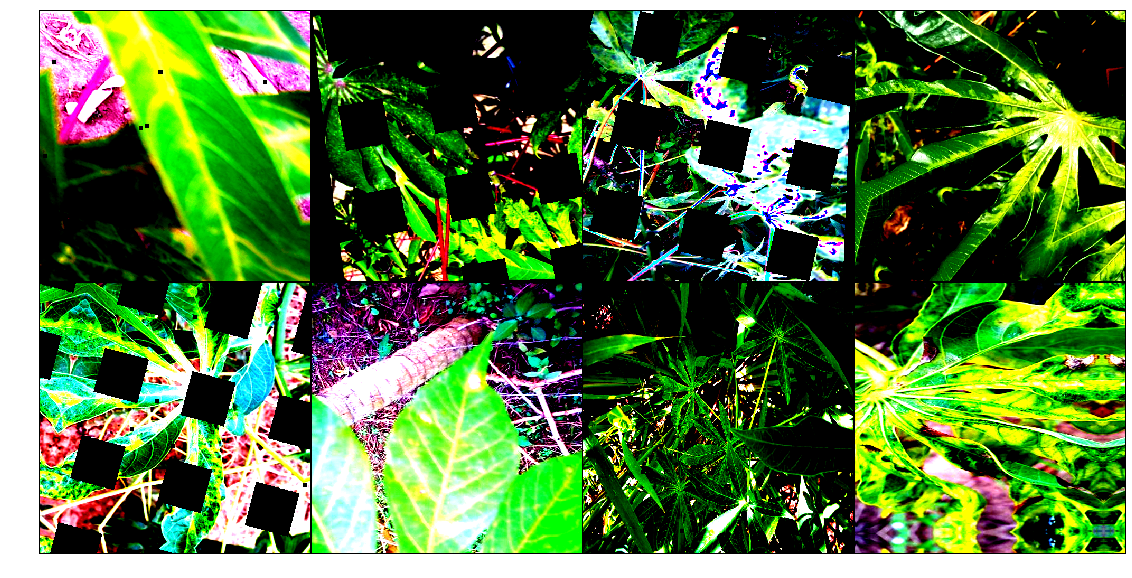

tensor([1, 3, 2, 3, 3, 0, 4, 3])


In [9]:
train_dataset = CassavaDataset(
    file_paths=TRAIN_DF.path,
    labels=TRAIN_DF.label,
    transform=train_transform,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=CFG.batch_size,
    shuffle=True, 
    num_workers=0
)

num_samples = 8

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(images[:num_samples], nrow=4))
print(labels[:num_samples])

del num_samples, images, labels, dataiter
del train_dataset, train_loader

# Model, Loss, Optimizer
## Model

In [10]:
class Net(nn.Module):
    # https://www.kaggle.com/sachinprabhu/pytorch-resnet50-snapmix-train-pipeline
    def __init__(self, model_arch, n_class, pretrained=False) :
        super().__init__()
        backbone = timm.create_model(model_arch, pretrained=pretrained)
        if 'resnet' in CFG.model :
            n_features = backbone.fc.in_features
            self.backbone = nn.Sequential(*backbone.children())[:-2]
        elif 'rexnet' in CFG.model :
            n_features = backbone.classifier.in_features
            self.backbone = nn.Sequential(*backbone.children())[:-1]
        else :
            n_features = backbone.classifier.in_features
            self.backbone = nn.Sequential(*backbone.children())[:-2]
        self.classifier = nn.Linear(n_features, n_class)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward_features(self, x):
        x = self.backbone(x)
        return x

    def forward(self, x):
        feats = self.forward_features(x)
        x = self.pool(feats).view(x.size(0),-1)
        x = self.classifier(x)
        return x, feats
    
# Net(CFG.model, len(CFG.classes))

## Set Loss, Optimizer, Scheduler

In [11]:
""" LOSS """
def set_loss() :
    if CFG.loss == 'cross_entropy' :
        criterion = nn.CrossEntropyLoss().to(CFG.device)
    elif CFG.loss == 'bi_tempered_logistic' :
        def bi_tempered_logistic_loss_fn(outputs, labels) :
            return bi_tempered_logistic_loss(outputs, labels,\
                        CFG.t0, CFG.t1, label_smoothing=CFG.label_smoothing)
        criterion = bi_tempered_logistic_loss_fn
    elif CFG.loss == 'smooth_cross_entropy' :
        criterion = SmoothCrossEntropyLoss(smoothing=CFG.label_smoothing).to(CFG.device)
    elif CFG.loss == 'focal_cosine' :
        criterion = FocalCosineLoss().to(CFG.device)
    elif CFG.loss == 'symmetric_cross_entropy' :
        criterion = SymmetricCrossEntropy(num_classes=len(CFG.classes)).to(CFG.device)
    elif CFG.loss == 'taylor_cross_entropy' :
        criterion = TaylorCrossEntropyLoss().to(CFG.device)
    else : 
        criterion = None
        
    assert criterion is not None
    return criterion

""" Optimizers """
def set_optimizer(model) :
    if CFG.optimizer == 'rmsprop' :
        optimizer = optim.RMSprop(model.parameters(), 
                                  lr=CFG.lr, momentum=CFG.momentum)
    elif CFG.optimizer == 'sgd' :
        optimizer = optim.SGD(model.parameters(), 
                              lr=CFG.lr, momentum=CFG.momentum)
    elif CFG.optimizer == 'adam' :
        optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
    elif CFG.optimizer == 'adamw' :
        optimizer = optim.AdamW(model.parameters(), 
                                lr=CFG.lr, betas=CFG.betas,
                               eps=CFG.eps, weight_decay=CFG.weight_decay, 
                                amsgrad=CFG.amsgrad)
    elif CFG.optimizer == 'ralamb' :
        optimizer = Ralamb(model.parameters(), lr=CFG.lr, 
                           weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sam' :
        optimizer = SAM(model.parameters(), optim.SGD,
                        lr=CFG.lr, momentum=CFG.momentum)
    elif CFG.optimizer == 'adamp' :
        optimizer = AdamP(model.parameters(), 
                          lr=CFG.lr, betas=CFG.betas,
                          weight_decay=CFG.weight_decay)
    else :
        optimizer = None
        
    if CFG.lookahead :
        optimizer = Lookahead(optimizer)
        
    if CFG.swa :
        optimizer = optim.swa_utils.SWALR(optimizer, anneal_epochs=10, swa_freq=2, swa_lr=CFG.min_lr, ) ## SWA
    
    assert optimizer is not None
    return optimizer

""" Scheduler """
def set_scheduler() :
    if CFG.scheduler == 'cosine' :
#         scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 2, eta_min=1e-6) # 1e-6  ### Cosine Warm 
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                   T_0=CFG.cos_t0, T_mult=1,
                                                                   eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler == 'steplr' :
        scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,
                                              step_size=5,
                                              gamma=0.5),
    else :
        scheduler = None
    
    return scheduler

## Train & Validate

In [12]:
folds = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, 
                        random_state=CFG.seed).split(np.arange(TRAIN_DF.shape[0]), 
                                                 TRAIN_DF.label.values)

print(CFG.model, CFG.loss, CFG.optimizer)
histories = []
filename = f'{CFG.model}_{CFG.time}'
print(filename)

tf_efficientnet_b7_ns bi_tempered_logistic ralamb
tf_efficientnet_b7_ns_20210122_211046


In [ ]:
%%time
for fold_num, (train_split, valid_split) in enumerate(folds):
    print('#'*20, 'Fold', fold_num, '#'*20)
    
    ################ Generate Dataset & Dataloader ###########################
    train_set = TRAIN_DF.iloc[train_split].reset_index(drop=True)
    valid_set = TRAIN_DF.iloc[valid_split].reset_index(drop=True)

    train_dataset = CassavaDataset(
        file_paths=train_set.path,
        labels=train_set.label,
        transform=train_transform,
        cache_ds=CFG.train_cache
    )

    valid_dataset = CassavaDataset(
        file_paths=valid_set.path,
        labels=valid_set.label,
        transform=valid_transform,
        cache_ds=CFG.valid_cache
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=CFG.batch_size,
        shuffle=True, 
        num_workers=0
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=CFG.batch_size,
        shuffle=False, 
        num_workers=0
    )
    
    if not CFG.train_cache :
        train_loader.num_workers = CFG.num_workers
    if not CFG.valid_cache :
        train_loader.num_workers = CFG.num_workers
    
    ################# Set Model, Loss, Optimizer, Scaler, Scheduler ###########################
    model = Net(CFG.model, len(CFG.classes), pretrained=True).to(CFG.device)
    criterion = set_loss()
    snapmix_criterion = SnapMixLoss().to(CFG.device)
    optimizer = set_optimizer(model)
    scaler = GradScaler()
    scheduler = set_scheduler()

    history = pd.DataFrame(columns=['loss','acc','val_loss','val_acc'])
    cached = False
    
    ## Early Stopping
    best_val_loss = np.inf
    best_epoch = 0
    
    for i, epoch in enumerate(range(CFG.epochs), len(history)):  # loop over the dataset multiple times

        ############## TRAIN ####################
        stime = time.time()
        running_loss = 0.0
        correct = 0
        total = 0

        model.train()
        for data in train_loader :

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(CFG.device)
            labels = labels.to(CFG.device)

            # forward + backward + optimize
            with autocast() :
                rand = np.random.rand()
                if rand > (1.0-CFG.snapmix_pct):
                    inputs, ya, yb, lam_a, lam_b = snapmix(inputs, labels, CFG.snapmix_alpha, model)
                    outputs, _ = model(inputs)
                    loss = snapmix_criterion(criterion, outputs, ya, yb, lam_a, lam_b)
                else:
                    outputs, _ = model(inputs)
                    loss = criterion(outputs, labels)
                
            scaler.scale(loss).backward()
    #         torch.nn.utils.clip_grad_norm_(model.parameters(), 1) ## Gradient Clipping
    
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
        
        train_loss = running_loss/len(train_loader)
        train_acc = correct/total*100

        
        ################ Validatioin ###################
        running_loss = 0.0
        correct = 0
        total = 0

        model.eval()
        with torch.no_grad():
            for data in valid_loader :
                inputs, labels = data
                inputs = inputs.to(CFG.device)
                labels = labels.to(CFG.device)
                with autocast() :
                    outputs, _ = model(inputs)
                    loss = criterion(outputs, labels)

                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        try :
            scheduler.step() ## Using scheduler
        except :
            pass
        
        training_time = time.time()-stime
        val_loss = running_loss/len(valid_loader)
        val_acc = correct/total*100
        history.loc[i] = [train_loss, train_acc, val_loss, val_acc]

        if CFG.verbose == 2 :
            print(f'[EPOCH {epoch+1}/{CFG.epochs}] time: {training_time:.2f}sec -',
                  f'loss: {train_loss:.4E} - acc: {train_acc:.2f}% -',
                  f'val_loss: {val_loss:.4E} - val_acc: {val_acc:.2f}%')

        if not cached and (CFG.train_cache or CFG.valid_cache) :
            if CFG.train_cache :
                train_loader.dataset.set_use_cache(use_cache=True)
                train_loader.num_workers = CFG.num_workers
            if CFG.valid_cache :
                valid_loader.dataset.set_use_cache(use_cache=True)
                valid_loader.num_workers = CFG.num_workers
            cached = True
            
        if CFG.save_best and best_val_loss > val_loss :
            best_val_loss = val_loss
            best_epoch = i
            torch.save(model.state_dict(), \
                       f'../output/{filename}_fold_{fold_num}.pt')
            
        if i - best_epoch >= CFG.early_stop_epochs :
            break
                
    histories.append(history)
    
    ### SWA
    try :
        optimizer.swap_swa_sgd()
#         torch.save(model.state_dict(), \
#                    f'../output/{filename}_fold_{fold_num}.pt')
    except :
        pass
    
    
    del model, optimizer, train_loader, valid_loader, scaler, scheduler
    del train_dataset, valid_dataset, train_set, valid_set
    torch.cuda.empty_cache()
        
print('Finished Training')

#################### Fold 0 ####################
[EPOCH 1/40] time: 3670.62sec - loss: 4.7848E-01 - acc: 62.78% - val_loss: 2.1446E-01 - val_acc: 81.46%
[EPOCH 2/40] time: 1411.58sec - loss: 3.6303E-01 - acc: 75.31% - val_loss: 1.6392E-01 - val_acc: 85.43%
[EPOCH 3/40] time: 1415.51sec - loss: 3.3734E-01 - acc: 77.40% - val_loss: 1.5400E-01 - val_acc: 86.47%
[EPOCH 4/40] time: 1411.28sec - loss: 3.2983E-01 - acc: 78.24% - val_loss: 1.4640E-01 - val_acc: 86.70%
[EPOCH 5/40] time: 1406.09sec - loss: 3.3102E-01 - acc: 78.73% - val_loss: 1.3553E-01 - val_acc: 87.65%


## Validation

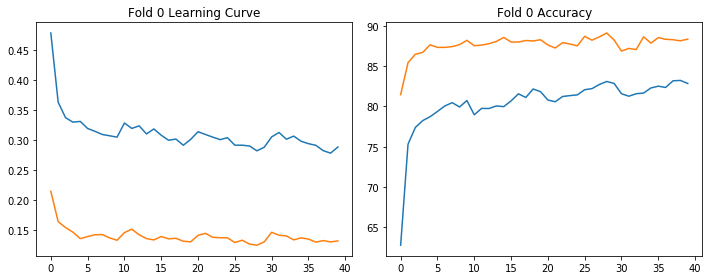

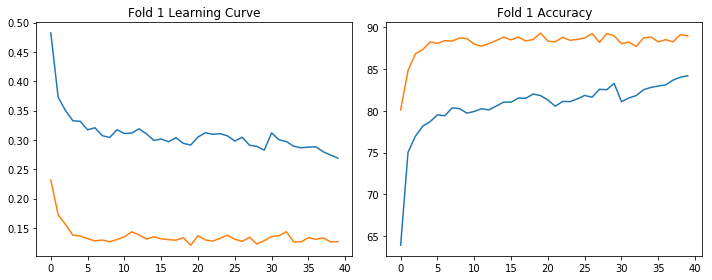

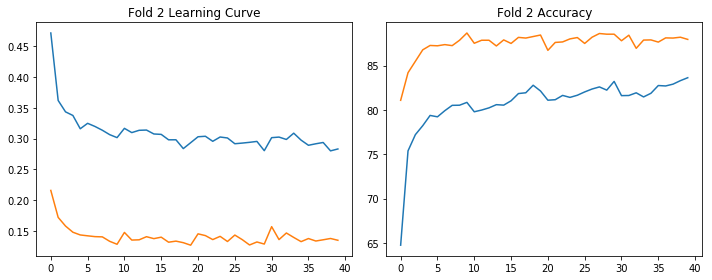

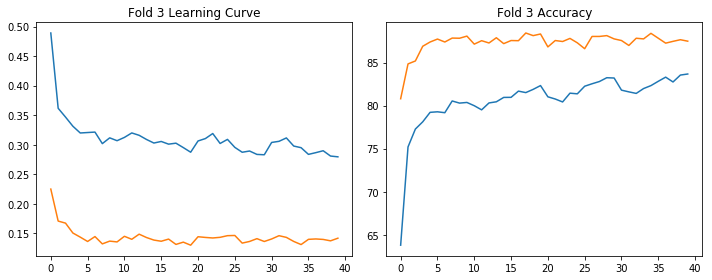

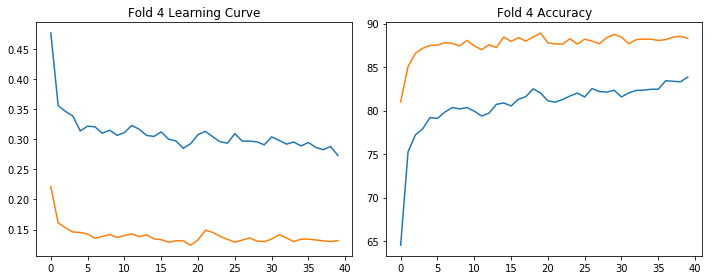

In [20]:
for i, history in enumerate(histories) :
    fig = plt.figure(figsize=(10,4))
    ax = plt.subplot(1,2,1)
    ax.plot(history.index, history.loss)
    ax.plot(history.index, history.val_loss)
    ax.set_title(f'Fold {i} Learning Curve')
    ax = plt.subplot(1,2,2)
    ax.plot(history.index, history.acc)
    ax.plot(history.index, history.val_acc)
    ax.set_title(f'Fold {i} Accuracy')
    plt.tight_layout()
    plt.show()

In [21]:
results = np.array([h.iloc[:, 3].max() for h in histories])
print(f'Max val_acc : {results.max():.2f}%',
      f'Ave val_acc : {results.mean():.2f}%',
      f'Min val_acc : {results.min():.2f}%', sep='\n') 

Max val_acc : 89.30%
Ave val_acc : 88.89%
Min val_acc : 88.44%


In [22]:
print(filename)
[histories[i].to_csv(f'../output/{filename}_fold_{i}.csv') for i in range(5)]
[histories[i].val_acc.argmax() for i in range(5)]

tf_efficientnet_b7_ns_20210122_211046


[28, 19, 9, 17, 19]

In [ ]:
### 1st Submission
# Max val_acc : 89.42%
# Ave val_acc : 89.15%
# Min val_acc : 88.87%

### 2nd Submission : tf_efficientnet_b4_ns & soft CE
# Max val_acc : 90.00%
# Ave val_acc : 89.68%
# Min val_acc : 89.55%

In [ ]:
# class_correct = list(0. for i in range(len(CFG.classes)))
# class_total = list(0. for i in range(len(CFG.classes)))

# with torch.no_grad():
#     for data in valid_loader:
#         inputs, labels = data[0].to(CFG.device), data[1].to(CFG.device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(len(labels)):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# print(f'Accuracy Total : {sum(class_correct)/sum(class_total)*100:.2f}%')
# for i in range(len(CFG.classes)):
#     print(f'Accuracy of {CFG.classes[i]:2d} : {100 * class_correct[i] / class_total[i]:.2f}%')

In [ ]:
# save = torch.save(model.state_dict(), '../output/model_rmsprop.pt')